In [1]:
%load_ext autoreload
%autoreload 2
import yaml
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
pd.options.mode.chained_assignment = None
# import warnings
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
opj = os.path.join
opd = os.path.dirname
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from utils import *
from analyse import *

Z = norm.ppf

In [5]:
# out='sub-004_ses-1_task-contrastL_run-3'
out='sub-009_ses-1_task-contrastL_run-6'

sub=out.split('_')[0]
tsk=out.split('_')[2].split('-')[-1][:-1]
attn=out.split('_')[2][-1].lower()
name='exp'
""
beh = AnalyseRun(out, tsk, attn,sub,name)
# beh.analyse2afc()
beh.analyseYesNo()

Settings file:  /data1/projects/dumoulinlab/Lab_members/Sumiya/programs/pRF_attention_task/Experiment/expsettings/expsettings_yesnoL.yml

Attention L
Proportions: [0.35, 0.65]
Response Keys: ['nan' 'b']

small D': 2.796, C: 0.967

21 expected responses                        
16 actual subject responses                        
14 hits (within 1s)                        
7 misses                        
2 false alarms                        
Average RT: 0.733s



In [29]:
summary=dd(dict)

summary
summary['cond'],summary['prop'],summary

'sub-004_ses-1_task-contrastH_run-2'

In [58]:
# summary
fnames=sorted([f for f in os.listdir(opj(beh.wd,'logs',sub)) if tsk in f ])
fnames

['sub-004_ses-1_task-contrastH_run-11_Logs',
 'sub-004_ses-1_task-contrastH_run-2_Logs',
 'sub-004_ses-1_task-contrastH_run-5_Logs',
 'sub-004_ses-1_task-contrastH_run-8_Logs',
 'sub-004_ses-1_task-contrastL_run-10_Logs',
 'sub-004_ses-1_task-contrastL_run-12_Logs',
 'sub-004_ses-1_task-contrastL_run-13_Logs',
 'sub-004_ses-1_task-contrastL_run-1_Logs',
 'sub-004_ses-1_task-contrastL_run-3_Logs',
 'sub-004_ses-1_task-contrastL_run-4_Logs',
 'sub-004_ses-1_task-contrastL_run-6_Logs',
 'sub-004_ses-1_task-contrastL_run-7_Logs',
 'sub-004_ses-1_task-contrastL_run-9_Logs']

In [8]:
outdir=opj(os.environ['DIR_DATA_DERIV'],'figs/beh')
if not os.path.exists(outdir):
    os.makedirs(outdir)

outstr=opj(outdir,sub+'_dprime.png')

'/data1/projects/dumoulinlab/Lab_members/Sumiya/projects/pRF_contrast/derivatives/figs/beh/sub-002_dprime.png'

In [15]:
getattr(beh,'c')

0.290030599631233

In [16]:
pars={'par': 'c', 'title': 'criterion'}
pars['title']

'criterion'

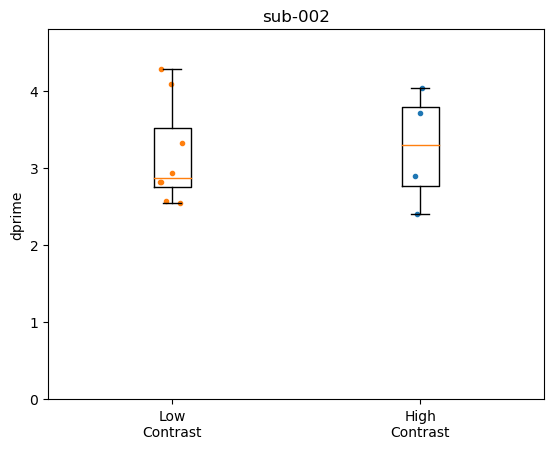

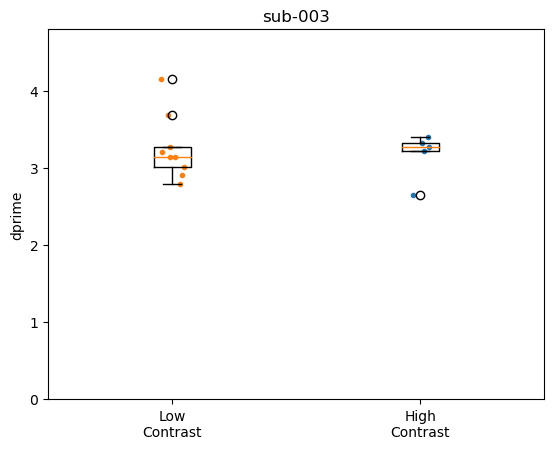

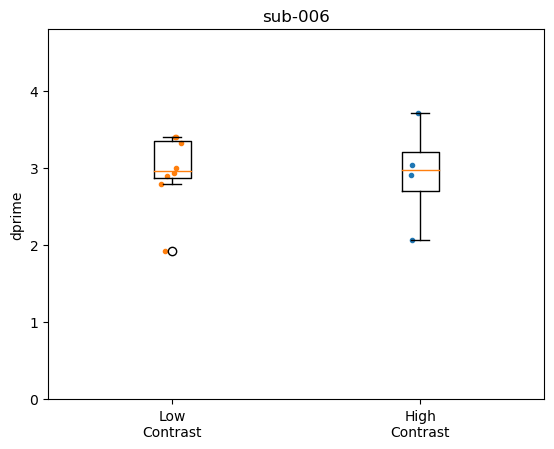

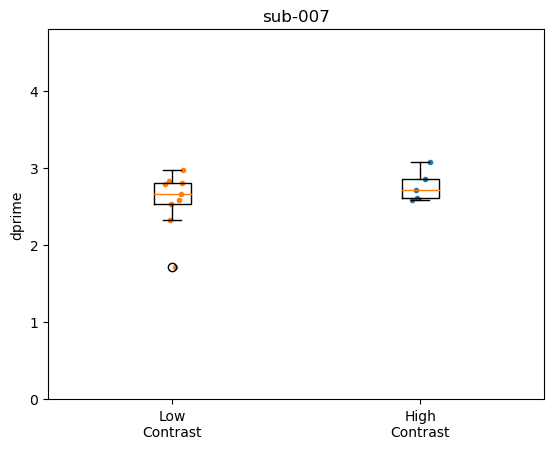

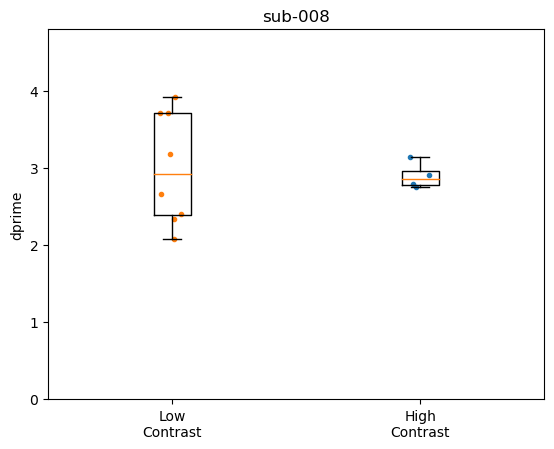

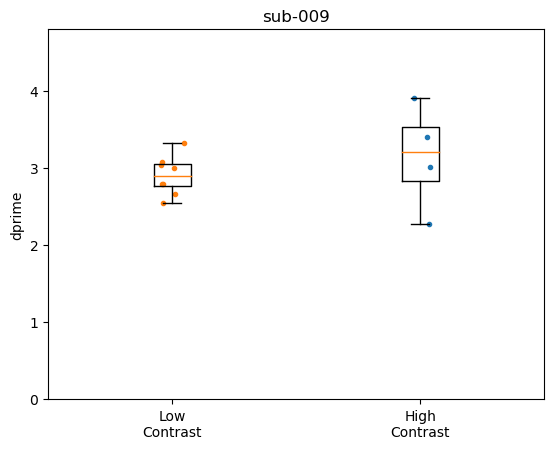

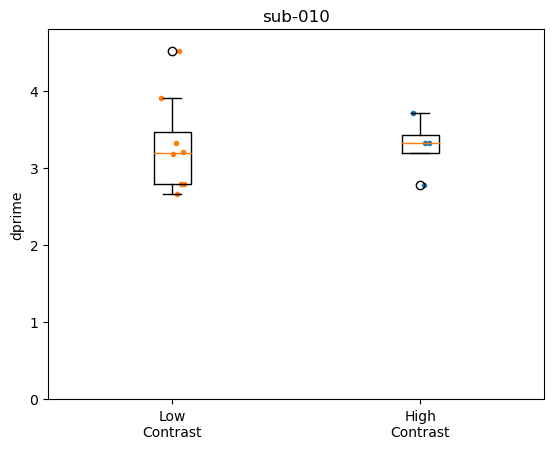

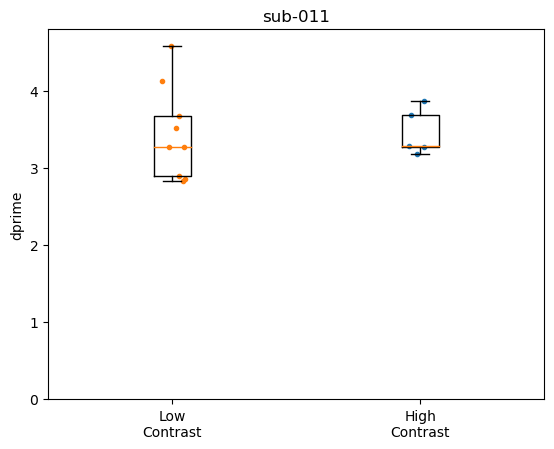

In [25]:
outdir=opj(os.environ['DIR_DATA_DERIV'],'figs/beh')
if not os.path.exists(outdir):
    os.makedirs(outdir)

n='exp'
substr=''#'ses-3_task-yesno'
if (substr == '') & (n == 'train'):
    substr='ses-0_task-yesno'
elif substr == '':
    substr='ses-1_task-contrast'
r=None
excl=['run-22']
# pars={'par': 'c', 'title': 'criterion', 'ylim': [0,1.7]}
pars={'par': 'd', 'title': 'dprime', 'ylim': [0,4.8]}
# pars={'par': 'rt', 'title': 'RT', 'ylim': [0,1.15]}

outdir=opj(os.environ['DIR_DATA_DERIV'],f'figs/beh/{pars["title"]}')
if not os.path.exists(outdir):
    os.makedirs(outdir)

for sub in ['sub-002','sub-003','sub-006','sub-007','sub-008','sub-009','sub-010','sub-011']:
    pth=opj(os.getcwd(),'logs',sub)
    fn=os.listdir(pth)#os.listdir(opj(os.environ['DIR_DATA_HOME'],f'sourcedata/{sub}/ses-1/prf/'))
    fn=[f for f in fn if substr in f]
    dL=[]
    dS=[]

    outstr=opj(outdir,sub+f'_{pars["title"]}.png')

    fig,ax=plt.subplots(1,1)

    for f in fn:
        if any([ex in f for ex in excl]):
            continue 
        out=f[:-5]
        tsk=out.split('_')[2].split('-')[-1][:-1]
        attn=out.split('_')[2][-1].lower()
        name=n
        beh = AnalyseRun(out, tsk, attn,sub,name,verbose=False)
        beh.analyseYesNo(resp=r)
        if attn == 'l': 
            dL.append(getattr(beh,pars['par']))
        else:
            dS.append(getattr(beh,pars['par']))

    ax.boxplot([dL,dS])
    ax.scatter(np.random.uniform(1.95,2.05,len(dS)),dS,marker='.')
    ax.scatter(np.random.uniform(0.95,1.05,len(dL)),dL,marker='.')
    ax.set_ylim(pars['ylim'])
    ax.set_xticks([2,1],['High\nContrast','Low\nContrast'])
    ax.set_ylabel(pars['title'])
    ax.set_title(f'{sub}')
    fig.savefig(outstr)